# Model `ELBMFNumPy`

Unofficial Python implementation of ELBMF.
https://github.com/renfujiwara/ELBMF

In [30]:
# use project files rather than the installed PyBMF
 
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, '../')

from PyBMF.utils import show_matrix

import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load `CustomData`

In [31]:
# # loading real-world data from datasets of ELBMF-Julia
# # download and extract .tsv file from https://eda.rg.cispa.io/prj/elbmf/

# # make sure the data is correctly parsed (right header, sep, etc.)

# df = pd.read_csv('D:\PyBMF-bulky\data\data-elbmf\Brain_Cerebellum-z.tsv', header=None, sep='\t')

# X = csr_matrix(df.astype(pd.SparseDtype("float64", 0)).sparse.to_coo())
# show_matrix([(X, [0, 0], 'data')])

# # wrap it with CustomData(), so that it can be easily cropped and displayed

# from PyBMF.datasets import CustomData

# data = CustomData(X, name="Brain_Cerebellum-z")
# data.load(overwrite_cache=True)

# data.sample(factor_id=1, n_samples=1000, seed=1000)
# data.show_matrix(scaling=0.25)

# Load synthetic data

In [32]:
# # generating synthetic data

# from PyBMF.generators import BlockDiagonalMatrixGenerator

# data = BlockDiagonalMatrixGenerator(m=300, n=500, k=5, overlap=[0.3, 0.2])
# data.generate(seed=1000)
# data.add_noise(noise=[0.4, 0.1], seed=2000)

# data.show_matrix(scaling=0.5)

# Load `MovieLensData`

[I] Sampling axis 0 to size 300
[I]   sampling seed: 1000
[I]   sampling from: (943, 1682)
[I]   sampling to  : (300, 1682)
[I] Sampling axis 1 to size 500
[I]   sampling seed: 1000
[I]   sampling from: (300, 1682)
[I]   sampling to  : (300, 500)


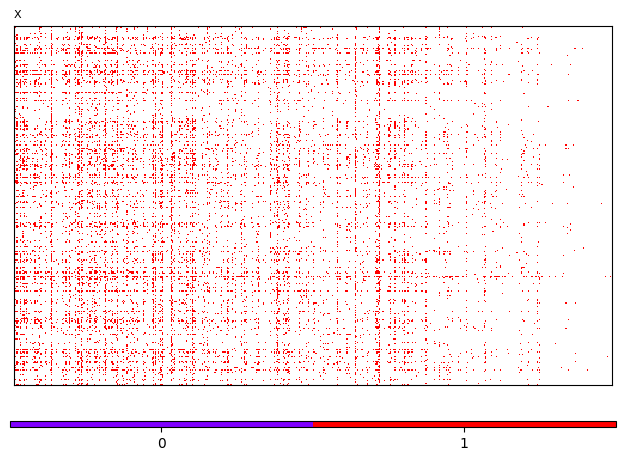

<Figure size 640x480 with 0 Axes>

In [33]:
# loading real-world data

from PyBMF.datasets import MovieLensData

data = MovieLensData(size="100k")
data.load()

idx = data.sample(factor_id=0, n_samples=300, seed=1000)
idx = data.sample(factor_id=1, n_samples=500, seed=1000)

data.show_matrix(scaling=0.5)

# Split and negative sampling

Here `NoSplit` is used, which means `X_train`, `X_val` and `X_test` point to the same data `data.X`.

With `split.negative_sample`, zeros are added to the sparse matrix. The number of zeros is set to be equal to the number of ones, which is `split.pos_size`.

In [34]:
# splitting the data into train, validation and test

from PyBMF.datasets import RatioSplit, NoSplit

# split = RatioSplit(X=data.X, val_size=0.1, test_size=0.2, seed=1997)
split = NoSplit(X=data.X)

# split.negative_sample(
#     train_size=split.pos_train_size, 
#     val_size=split.pos_val_size, 
#     test_size=split.pos_test_size, 
#     seed=2023, type='popularity')
split.negative_sample(
    size=split.pos_size, 
    seed=2023, type='popularity')

X_train, X_val, X_test = split.X_train, split.X_val, split.X_test

[I] NoSplit, sampling positives
[I] RatioSplit, sampling positives
[I]   seed         : 1725618061
[I]   train_size   : 10754
[I]   val_size     : 0
[I]   test_size    : 0
[I]   seed         : 1725618061
[I] RatioSplit, sampling negatives
[I]   seed         : 2023
[I]   all_negatives: 139246
[I]   n_negatives  : 10754
[I]   train_size   : 10754
[I]   val_size     : 0
[I]   test_size    : 0
[I]   seed         : 2023


# `ELBMFNumPy`

init_loss
recall : 1.0, similarity : 0.9283066666666666, relative loss : 1497451484.0


100%|██████████| 100/100 [00:17<00:00,  5.71it/s]

result_loss
recall : 0.1511065649990701, similarity : 0.06261333333333333, relative loss : 101001568.0


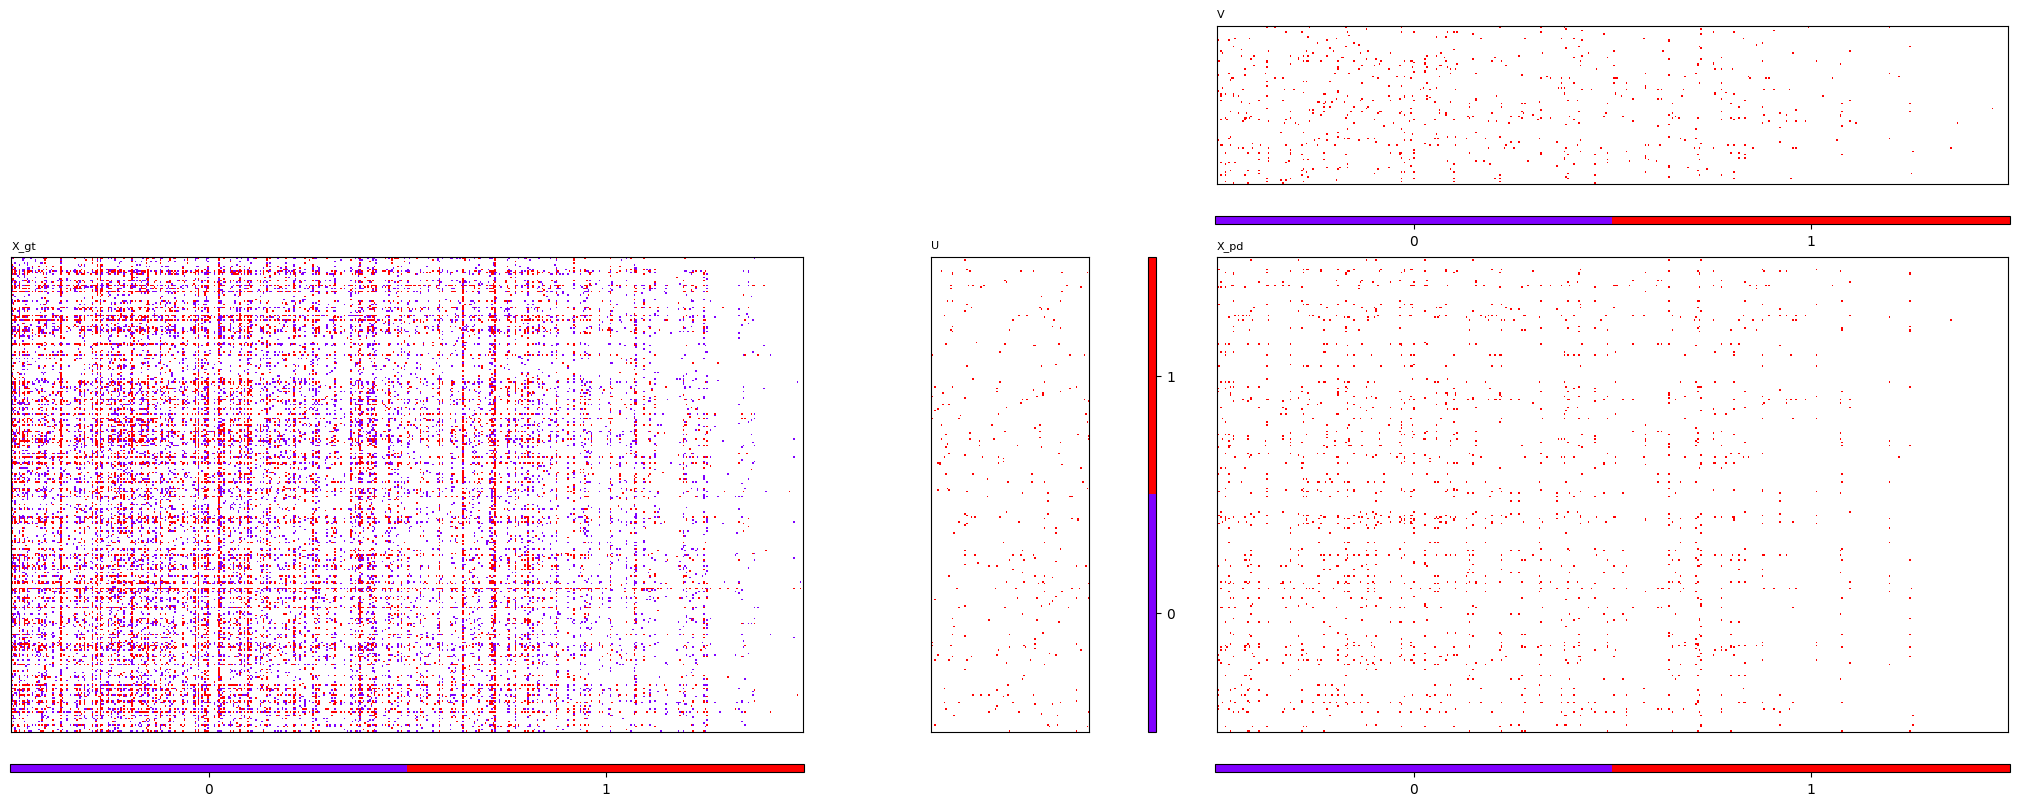

<Figure size 640x480 with 0 Axes>

In [35]:
from PyBMF.models.ELBMFNumPy import ELBMF, _rounding, _print_loss, _product
from PyBMF.utils import show_matrix, to_dense, to_sparse, binarize, matmul

k = 100
l1reg = 0.01
l2reg = 0.02
c = 1.0002
maxiter = 100
tolerance = 1e-8
beta = 0.0 # if beta > 0 -> use iPALM else use PALM
random_seed = 1000

X_clean = to_dense(X_train)
X_noise = to_dense(X_train)

model = ELBMF(X_clean, X_noise, k, l1reg, l2reg, c, maxiter, tolerance, random_seed, beta)

model.factorize()

# Check reconstructed matrix

Insert the script into ELBMFNumPy.py to show intermediate results.

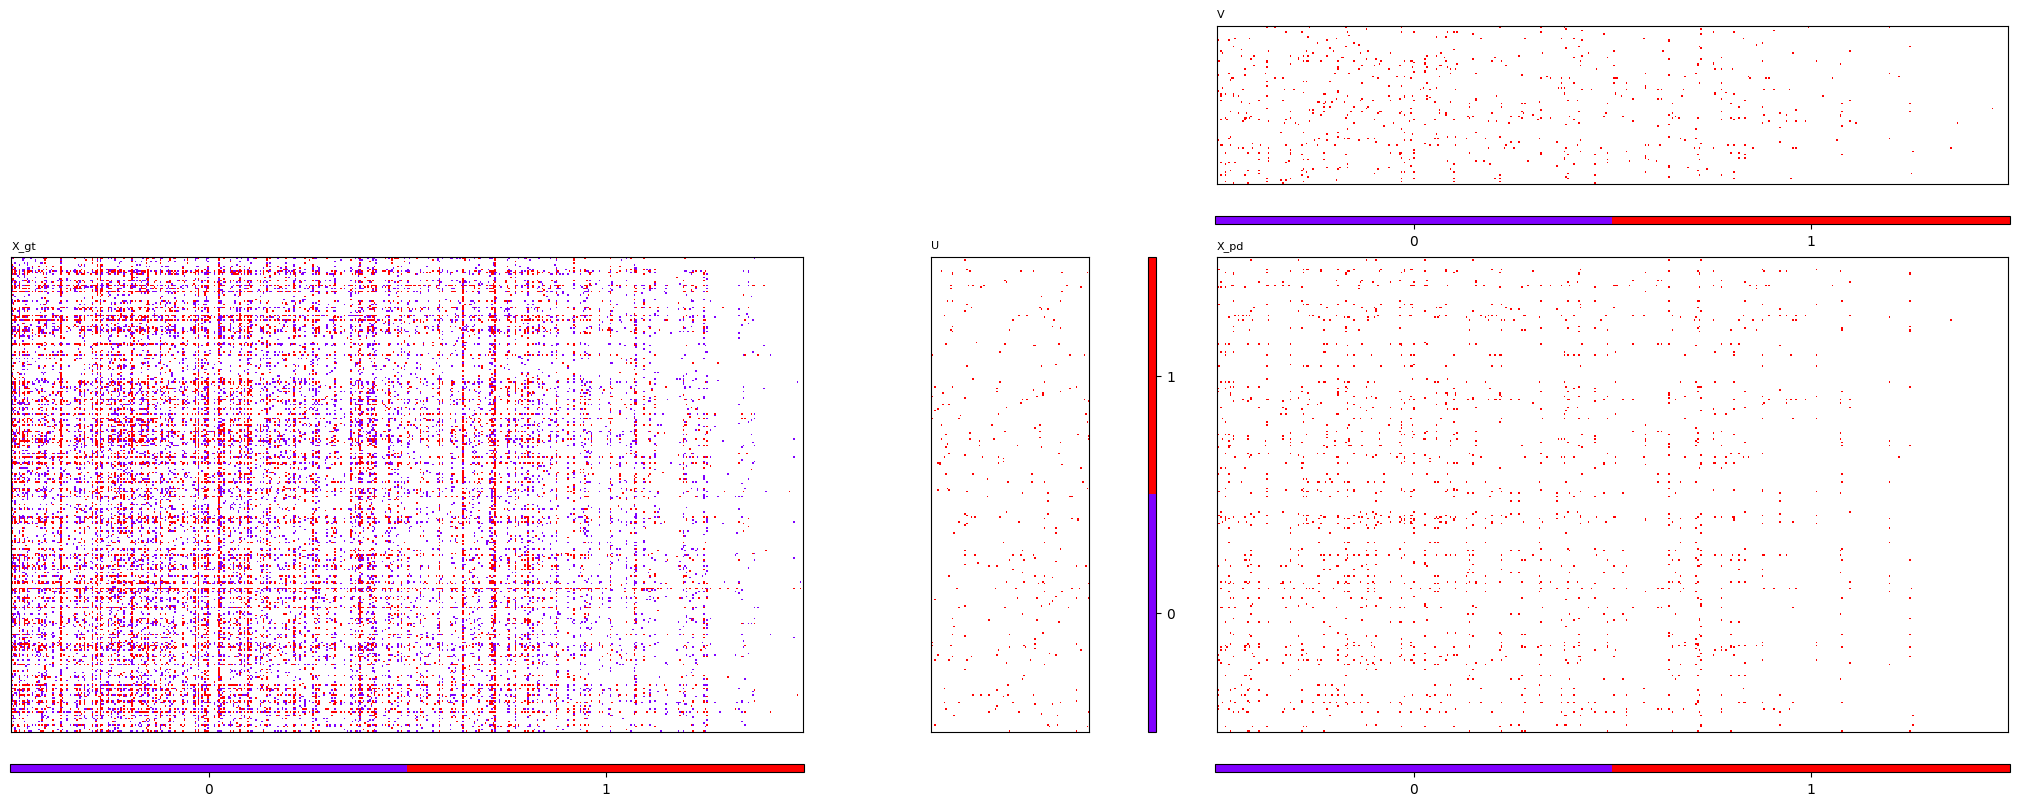

<Figure size 640x480 with 0 Axes>

In [38]:
U = to_sparse(binarize(model.U))
V = to_sparse(binarize(model.V))
X_pd = matmul(U, V, sparse=True, boolean=True)

show_matrix([(U, [1, 1], 'U'), (V, [0, 2], 'V'), (X_pd, [1, 2], 'X_pd'), (X_train, [1, 0], 'X_gt')], colorbar=True, discrete=True, clim=[0, 1])

# Check real-valued loss

In [36]:
model.logs['updates']

train           
                                                               0           
                  time iter             F         ell       RMSE        MAE
0    06/09/24 06:21:01    0  9.418701e+07  362.263112  25.058200  24.958544
1    06/09/24 06:21:01    0  7.251728e+05  362.259284   2.198746   2.156177
2    06/09/24 06:21:02    1  8.430215e+04  265.412079   0.749676   0.714858
3    06/09/24 06:21:02    2  2.462513e+04  123.233220   0.405176   0.385367
4    06/09/24 06:21:02    3  1.358383e+04   70.217403   0.300930   0.264924
..                 ...  ...           ...         ...        ...        ...
96   06/09/24 06:21:18   95  3.926224e+03   10.332386   0.161786   0.078589
97   06/09/24 06:21:18   96  3.911613e+03   10.329383   0.161485   0.078388
98   06/09/24 06:21:18   97  3.897213e+03   10.326500   0.161188   0.078191
99   06/09/24 06:21:19   98  3.882989e+03   10.323070   0.160893   0.077995
100  06/09/24 06:21:19   99  3.868960e+03   10.319907   0.160602   0.077803

[101 rows x 6 columns]

# Check Boolean error

In [37]:
model.logs['boolean']

train                              
                                    0                              
                  time iter    Recall Precision  Accuracy        F1
0    06/09/24 06:21:01    0  1.000000  0.071693  0.071693  0.133794
1    06/09/24 06:21:01    0  0.194346  0.085261  0.792753  0.118524
2    06/09/24 06:21:02    1  0.000000  0.000000  0.928307  0.000000
3    06/09/24 06:21:02    2  0.000000  0.000000  0.928307  0.000000
4    06/09/24 06:21:02    3  0.000000  0.000000  0.928307  0.000000
..                 ...  ...       ...       ...       ...       ...
96   06/09/24 06:21:18   95  0.144504  0.859513  0.936973  0.247413
97   06/09/24 06:21:18   96  0.146364  0.860580  0.937100  0.250179
98   06/09/24 06:21:18   97  0.146457  0.859247  0.937087  0.250258
99   06/09/24 06:21:19   98  0.148503  0.861846  0.937247  0.253351
100  06/09/24 06:21:19   99  0.151107  0.860699  0.937387  0.257080

[101 rows x 6 columns]